# RTF Model for predicting Racket Type with Enveloppe - Vibrations

Import

In [1]:
import os
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.fft import fft
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.signal import hilbert

ReadCsv function

Colonnes du fichier P1_RB_4_C_1.csv : (2401, 1)


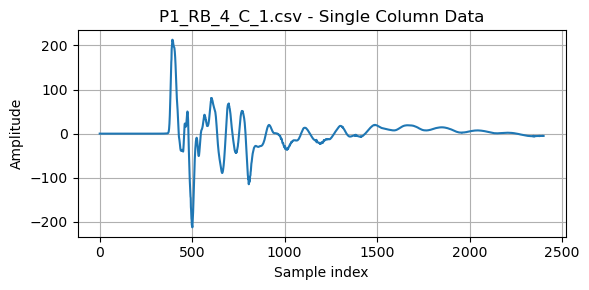

Colonnes du fichier P1_RB_3_S_2.csv : (2401, 1)


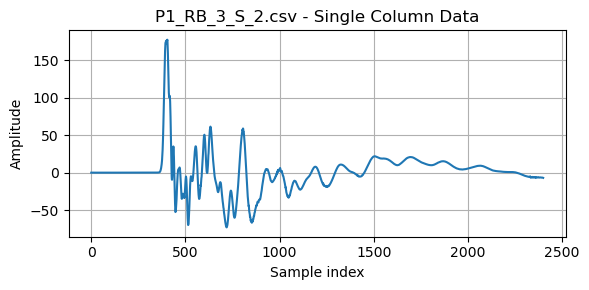

In [2]:
def readCsvFolder(folderPath):
    fileFolder = []
    files = []
    for filepath in glob.glob(os.path.join(folderPath, '*.csv')):
        try:
            data = pd.read_csv(filepath, header=None)  # On suppose pas d'en-têtes
            fileFolder.append(data)
            files.append(os.path.basename(filepath))
        except Exception as e:
            print(f"Erreur lors de la lecture de {filepath} : {e}")
    return fileFolder, files

# Lecture des fichiers
csv_data_list, filenames = readCsvFolder("../../Data_Clean/Chanel0_Data_Columns/P1_clean/RB")

# Affichage
for i,csv_data in enumerate(csv_data_list[:2]):
    print(f"Colonnes du fichier {filenames[i]} :",csv_data.shape)

    plt.figure(figsize=(6, 3))
    if csv_data.shape[1] >= 2:
        time_axis = range(len(csv_data.iloc[:, 1]))  # Pas de vraie échelle de temps si on ne l'a pas
        plt.plot(time_axis, csv_data.iloc[:, 1], label="Amplitude")
        plt.xlabel("Sample index")
        plt.ylabel("Amplitude")
        plt.title(f"{filenames[i]} - Channel 1")
    else:
        plt.plot(csv_data.iloc[:, 0])
        plt.title(f"{filenames[i]} - Single Column Data")
        plt.xlabel("Sample index")
        plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Spectrum

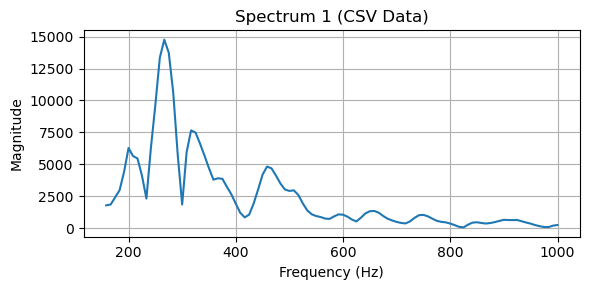

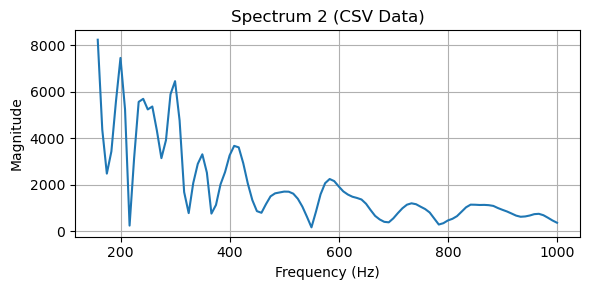

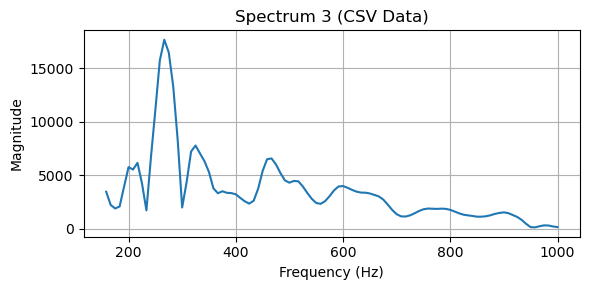

In [3]:
def spectrumFromCsv(csv_data, sample_rate):
    """Calcule le spectre à partir d'un signal CSV"""
    signal = csv_data.iloc[:, 0].values  # extrait la colonne souhaitée
    spectrum = fft(signal)
    magnitude = abs(spectrum[:len(spectrum) // 2])
    freqs = np.fft.fftfreq(len(signal), d=1/sample_rate)[:len(spectrum) // 2]
    return freqs, magnitude

sample_rate = 20000

spectrumVect = []

for csv_data in csv_data_list:
    freqs, spectrum = spectrumFromCsv(csv_data, sample_rate)
    # Filtrage de la bande [150 Hz, 1000 Hz]
    band_mask = (freqs >= 150) & (freqs <= 1000)
    filtered_freqs = freqs[band_mask]
    filtered_spectrum = spectrum[band_mask]
    spectrumVect.append((filtered_freqs, filtered_spectrum))


# Visualisation des spectres pour les données CSV
for idx, (freqs, spectrum) in enumerate(spectrumVect[:3]):
    plt.figure(figsize=(6, 3))
    plt.plot(freqs, spectrum)
    plt.title(f"Spectrum {idx + 1} (CSV Data)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Extract each peak and store

In [4]:
def extractNPeak(n_peak,signal):
    # Find peaks in the signal
    peaks = np.argsort(signal)[-n_peak:]  # Get indices of the n largest peaks
    peaks = np.sort(peaks)  # Sort the indices in ascending order

    # Extract the peak values
    peak_values = signal[peaks]

    return peaks, peak_values


# Fonction pour lire les fichiers d'un dossier donné
def lire_fichiers_dossier(dossier):
    if os.path.exists(dossier):  # Vérifier si le dossier existe
        return readCsvFolder(dossier)
    else:
        print(f"Dossier introuvable : {dossier}")
        return [], [], []  # Retourne des listes vides si le dossier n'existe pas
    
def energy_per_frequency_band_from_spectrum(spectrum, freqs, band_width):
    # Calculate energy per band
    band_energies = []
    band_frequencies = []
    for start_freq in range(0, int(freqs[-1]), band_width):
        end_freq = start_freq + band_width
        band_indices = np.where((freqs >= start_freq) & (freqs < end_freq))[0]
        band_energy = np.sum(spectrum[band_indices]**2)  # Sum of squared magnitudes
        band_energies.append(band_energy)
        band_frequencies.append((start_freq + end_freq) / 2)  # Center frequency of the band

    return band_energies, band_frequencies

def envelope_from_spectrum(spectrum):
    # Compute the analytic signal using the Hilbert transform
    analytic_signal = hilbert(spectrum)
    # Compute the envelope as the magnitude of the analytic signal
    envelope = np.abs(analytic_signal)
    return envelope


## Main

In [5]:
# Liste des types de raquettes et zones
raquetteTypeList = {"RB":0, "RO":1, "RR":2, "RV":3}
racket_ages = {"P1":1, "P2":2, "P3":3}

allCsvFile=[]
allCsvFileLabel=[]
allCsvFileRB=[]
allCsvFileRO=[]
allCsvFileRR=[]
allCsvFileRV=[]
results = []


for ages in racket_ages:
    fileFolderRB,filesRB = readCsvFolder("../../Data_Clean/Chanel0_Data_Columns/"+ages+"_clean/RB")
    if ages == "P1":
        fileFolderRB = [df for df, path in zip(fileFolderRB, filesRB) if "_C." in os.path.basename(path)]
    allCsvFileRB.extend(fileFolderRB)
    
    fileFolderRO,filesRO = readCsvFolder("../../Data_Clean/Chanel0_Data_Columns/"+ages+"_clean/RO")
    if ages == "P1":
        fileFolderRO = [df for df, path in zip(fileFolderRO, filesRO) if "_C." in os.path.basename(path)]
    allCsvFileRO.extend(fileFolderRO)

    fileFolderRR,filesRR = readCsvFolder("../../Data_Clean/Chanel0_Data_Columns/"+ages+"_clean/RR")
    if ages == "P1":
        fileFolderRR = [df for df, path in zip(fileFolderRR, filesRR) if "_C." in os.path.basename(path)]
    allCsvFileRR.extend(fileFolderRR)

    fileFolderRV,filesRV = readCsvFolder("../../Data_Clean/Chanel0_Data_Columns/"+ages+"_clean/RV")
    if ages == "P1":
        fileFolderRV = [df for df, path in zip(fileFolderRV, filesRV) if "_C." in os.path.basename(path)]
    allCsvFileRV.extend(fileFolderRV)


# Find the minimum length among the three lists
min_len = min(len(allCsvFileRB), len(allCsvFileRO), len(allCsvFileRR), len(allCsvFileRV))

# Reduce each list to the minimum length
allCsvFileRB = allCsvFileRB[:min_len]
allCsvFileRO = allCsvFileRO[:min_len]
allCsvFileRR = allCsvFileRR[:min_len]
allCsvFileRV = allCsvFileRV[:min_len]

print("Len(allCsvFileRB)",len(allCsvFileRB),"Len(allCsvFileRO)",len(allCsvFileRO),"Len(allCsvFileRR)",len(allCsvFileRR),"Len(allCsvFileRV)",len(allCsvFileRV))


# print(len(sampleRateFolderP1))

for csvFile in allCsvFileRB:
    allCsvFile.append(csvFile)
    allCsvFileLabel.append("RB")
for csvFile in allCsvFileRO:
    allCsvFile.append(csvFile)
    allCsvFileLabel.append("RO")
for csvFile in allCsvFileRR:
    allCsvFile.append(csvFile)
    allCsvFileLabel.append("RR")
for csvFile in allCsvFileRV:
    allCsvFile.append(csvFile)
    allCsvFileLabel.append("RV")
    
bestHZAllCsvFile = []
bestAmplitudeAllCsvFile = []

for csvFile in allCsvFile:
    # Compute the spectrum using FFT
    freqs, spectrum = spectrumFromCsv(csvFile, sample_rate)
    band_mask = (freqs >= 150) & (freqs <= 1000)
    filtered_spectrum = spectrum[band_mask]
    # Extract peaks from the spectrum
    envelope = envelope_from_spectrum(filtered_spectrum)
    bestAmplitudeAllCsvFile.append(envelope)

    # Normaliser les amplitudes
max_amp = max(np.max(amp) for amp in bestAmplitudeAllCsvFile)
bestAmplitudeAllCsvFile = [amp / max_amp for amp in bestAmplitudeAllCsvFile]

# Combine features into X
X = np.array(bestAmplitudeAllCsvFile)

# Encode string labels into integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(allCsvFileLabel)

# Diviser les données en ensembles d'entraînement et de test
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Définir les bonnes valeurs trouvé
n_estimators_range = [10, 50, 100]
max_depth_range = [None, 10, 20, 30]
min_samples_split_range = [2, 5, 10]

# Tester toutes les combinaisons d'hyperparamètres
for n_estimators in n_estimators_range:
    for max_depth in max_depth_range:
        for min_samples_split in min_samples_split_range:
            rf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                random_state=42
            )
            rf.fit(X_train, y_train)
            # Évaluer sur l'ensemble de test
            y_pred = rf.predict(X_test)
            accuracy_test = accuracy_score(y_test, y_pred)

            # Évaluer sur l'ensemble d'entraînement
            y_train_pred = rf.predict(X_train)
            accuracy_train = accuracy_score(y_train, y_train_pred)

            results.append({
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'accuracy_train': accuracy_train,
                'accuracy_test': accuracy_test
            })
                
# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)

# Enregistrer les résultats dans un fichier Excel
results_df.to_excel("V_RTF_Raquette_P1.P2.P3_Enveloppe2.xlsx", index=False)

print("Results have been saved to 'RTF_Raquette_P1.P2.P3_Enveloppe.xlsx'.")

# Trier les résultats par ordre décroissant de 'accuracy_test'
sorted_results_df = results_df.sort_values(by='accuracy_test', ascending=False)

# Afficher les résultats triés
print(sorted_results_df)

Len(allCsvFileRB) 134 Len(allCsvFileRO) 134 Len(allCsvFileRR) 134 Len(allCsvFileRV) 134
Results have been saved to 'RTF_Raquette_P1.P2.P3_Enveloppe.xlsx'.
    n_estimators  max_depth  min_samples_split  accuracy_train  accuracy_test
0             10        NaN                  2             1.0       1.000000
27           100       10.0                  2             1.0       1.000000
21            50       30.0                  2             1.0       1.000000
22            50       30.0                  5             1.0       1.000000
23            50       30.0                 10             1.0       1.000000
24           100        NaN                  2             1.0       1.000000
25           100        NaN                  5             1.0       1.000000
26           100        NaN                 10             1.0       1.000000
28           100       10.0                  5             1.0       1.000000
19            50       20.0                  5             1.0   